In [2]:
from pathlib import Path

import pandas as pd
import seaborn as sns


In [5]:
SEEDS = [1256870834, 255462424, 1143060359]

In [36]:
test_results_df = pd.read_csv("test_results.csv")

test_results_df.head()

seed   searcher scheduler  test_accuracy  trials  \
0  1256870834    RANDDOM      FIFO       0.673333     129   
1   255462424    RANDDOM      FIFO       0.601667     100   
2  1143060359    RANDDOM      FIFO       0.586667     116   
3  1256870834  WARMSTART      FIFO       0.752500     219   
4   255462424  WARMSTART      FIFO       0.724167     275   

                                              config  \
0  {'batch_size': 7, 'dropout_rate': 0.2, 'global...   
1  {'batch_size': 16, 'dropout_rate': 0.2, 'globa...   
2  {'batch_size': 140, 'dropout_rate': 0.2, 'glob...   
3  {'batch_size': 103, 'dropout_rate': 0.2, 'glob...   
4  {'batch_size': 56, 'dropout_rate': 0.2, 'globa...   

                                       hash  
0  73fa1044e65f7cd4ea52adace9425d786d97aaf8  
1  73fa1044e65f7cd4ea52adace9425d786d97aaf8  
2  73fa1044e65f7cd4ea52adace9425d786d97aaf8  
3  73fa1044e65f7cd4ea52adace9425d786d97aaf8  
4  73fa1044e65f7cd4ea52adace9425d786d97aaf8

In [9]:
CREATE_DATA = False

if CREATE_DATA:
    data_df = pd.DataFrame()

    for experiment in Path("./ray_tune/").iterdir():
        if experiment.is_dir():
            seed = SEEDS[int(experiment.name.split("_")[-1])-1]
            exp_name = experiment.name.rsplit("_", 1)[0]
            splits = experiment.name.split("_")
            scheduler = splits[1]
            searcher = splits[2].removeprefix("SEARCH")
            for trial in experiment.iterdir():
                if trial.is_dir():
                    try:
                        trial_result = pd.read_json(trial / "result.json", lines=True)
                        trial_result["scheduler"] = scheduler
                        trial_result["searcher"] = searcher
                        trial_result["seed"] = seed

                        data_df = pd.concat([data_df, trial_result])
                    except FileNotFoundError as fnfe:
                        print(fnfe)


    data_df = data_df.drop(columns=["pid", "hostname", "node_ip"])

    data_df.to_csv("tuning_results.csv", index=False)
else:
    data_df = pd.read_csv("tuning_results.csv") 

data_df.head()

val_accuracy_mean  time_this_iter_s should_checkpoint   done  \
0           0.207621          9.154274              True  False   
1           0.315731          1.941098              True  False   
2           0.404304          1.908924              True  False   
3           0.429436          1.854084              True  False   
4           0.526557          2.056859              True  False   

   training_iteration  trial_id                 date           timestamp  \
0                 1.0  ee857a0d  2023-08-21_21-26-17 2023-08-21 19:26:17   
1                 2.0  ee857a0d  2023-08-21_21-26-19 2023-08-21 19:26:19   
2                 3.0  ee857a0d  2023-08-21_21-26-21 2023-08-21 19:26:21   
3                 4.0  ee857a0d  2023-08-21_21-26-23 2023-08-21 19:26:23   
4                 5.0  ee857a0d  2023-08-21_21-26-25 2023-08-21 19:26:25   

   time_total_s                                             config  \
0      9.154274  {'batch_size': 189, 'dropout_rate': 0.2, 'glob...   
1     11.095372  {'batch_size': 189, 'dropout_rate': 0.2, 'glob...   
2     13.004296  {'batch_size': 189, 'dropout_rate': 0.2, 'glob...   
3     14.858380  {'batch_size': 189, 'dropout_rate': 0.2, 'glob...   
4     16.915239  {'batch_size': 189, 'dropout_rate': 0.2, 'glob...   

   time_since_restore  iterations_since_restore scheduler       searcher  \
0            9.154274                       1.0      FIFO  RANDDOMSEARCH   
1           11.095372                       2.0      FIFO  RANDDOMSEARCH   
2           13.004296                       3.0      FIFO  RANDDOMSEARCH   
3           14.858380                       4.0      FIFO  RANDDOMSEARCH   
4           16.915239                       5.0      FIFO  RANDDOMSEARCH   

        seed  
0  255462424  
1  255462424  
2  255462424  
3  255462424  
4  255462424

In [10]:
data_df["searcher"] = data_df["searcher"].astype("category")
data_df["scheduler"] = data_df["scheduler"].astype("category")
data_df["seed"] = data_df["seed"].astype("category")
data_df["should_checkpoint"] = data_df["should_checkpoint"].astype(bool)
data_df["training_iteration"] = data_df["training_iteration"].astype(int)
data_df["trial_id"] = data_df["trial_id"].astype("category")
data_df["done"] = data_df["done"].astype(bool)
data_df["iterations_since_restore"] = data_df["iterations_since_restore"].astype(int)


In [11]:
data_df.reset_index(drop=True, inplace=True)
# group by experiment and seed and get min timestamp
min_timestamps = data_df.groupby(["searcher", "scheduler", "seed"])["timestamp"].min()

# create column runtime with the difference between the timestamp and the min timestamp depending on the experiment and seed
data_df["runtime"] = data_df.apply(
    lambda row: (row["timestamp"] - min_timestamps[row["searcher"], row["scheduler"], row["seed"]]),
    axis=1,
)

data_df["runtime_minutes"] = data_df["runtime"].apply(lambda x: x.total_seconds() / 60)

In [12]:
performance_df = data_df.loc[data_df.groupby(["trial_id"])['val_accuracy_mean'].idxmax()]
performance_df.head()

val_accuracy_mean  time_this_iter_s  should_checkpoint   done  \
36641           0.134722         10.231966               True   True   
54651           0.142700          2.822537               True  False   
3416            0.120439          7.202291               True   True   
17423           0.603401          2.031559               True  False   
24611           0.225051          2.093562               True   True   

       training_iteration trial_id                 date           timestamp  \
36641                   1   272501  2023-08-23_05-08-34 2023-08-23 03:08:34   
54651                   2   324602  2023-08-21_17-53-57 2023-08-21 15:53:57   
3416                    1   399864  2023-08-23_02-18-27 2023-08-23 00:18:27   
17423                  17   765580  2023-08-22_23-56-13 2023-08-22 21:56:13   
24611                   4   813089  2023-08-23_07-24-57 2023-08-23 05:24:57   

       time_total_s                                             config  \
36641     10.231966  {'batch_size': 6, 'dropout_rate': 0.2, 'global...   
54651     12.356440  {'batch_size': 22, 'dropout_rate': 0.2, 'globa...   
3416       7.202291  {'batch_size': 46, 'dropout_rate': 0.2, 'globa...   
17423     42.009674  {'batch_size': 35, 'dropout_rate': 0.2, 'globa...   
24611     14.212051  {'batch_size': 482, 'dropout_rate': 0.2, 'glob...   

       time_since_restore  iterations_since_restore scheduler  \
36641           10.231966                         1      ASHA   
54651           12.356440                         2      FIFO   
3416             7.202291                         1      ASHA   
17423           42.009674                        17      DORA   
24611           14.212051                         4      ASHA   

              searcher        seed         runtime  runtime_minutes  
36641    RANDDOMSEARCH   255462424 0 days 03:14:24       194.400000  
54651  WARMSTARTSEARCH  1256870834 0 days 01:25:00        85.000000  
3416     RANDDOMSEARCH  1143060359 0 days 00:23:32        23.533333  
17423    RANDDOMSEARCH  1143060359 0 days 00:17:08        17.133333  
24611  WARMSTARTSEARCH  1143060359 0 days 05:27:37       327.616667

In [13]:
config_df = pd.DataFrame(
    performance_df["config"].to_list(), index=performance_df["trial_id"]
)
config_df = config_df.join(performance_df[["val_accuracy_mean", "trial_id", "searcher", "scheduler", "seed"]].set_index("trial_id"))
config_df.head()


batch_size  dropout_rate  global_avg_pooling  kernel_size  \
trial_id                                                              
272501             6           0.2               False            3   
324602            22           0.2               False            3   
399864            46           0.2                True            3   
765580            35           0.2               False            3   
813089           482           0.2               False            3   

          learning_rate_init  n_channels_conv_0  n_channels_fc_0  \
trial_id                                                           
272501              0.019915                101               88   
324602              0.300455                505              172   
399864              0.077555                 60              154   
765580              0.000737                166               52   
813089              0.000177                484               43   

          n_conv_layers  n_fc_layers  use_BN  n_channels_conv_1  \
trial_id                                                          
272501                1            1   False                NaN   
324602                3            1   False              433.0   
399864                2            1   False              249.0   
765580                3            3    True               16.0   
813089                3            1    True               55.0   

          n_channels_conv_2  n_channels_fc_1  n_channels_fc_2  \
trial_id                                                        
272501                  NaN              NaN              NaN   
324602                 70.0              NaN              NaN   
399864                  NaN              NaN              NaN   
765580                213.0             80.0             58.0   
813089                382.0              NaN              NaN   

          val_accuracy_mean         searcher scheduler        seed  
trial_id                                                            
272501             0.134722    RANDDOMSEARCH      ASHA   255462424  
324602             0.142700  WARMSTARTSEARCH      FIFO  1256870834  
399864             0.120439    RANDDOMSEARCH      ASHA  1143060359  
765580             0.603401    RANDDOMSEARCH      DORA  1143060359  
813089             0.225051  WARMSTARTSEARCH      ASHA  1143060359

## Rank plot

<AxesSubplot:xlabel='scheduler', ylabel='searcher'>

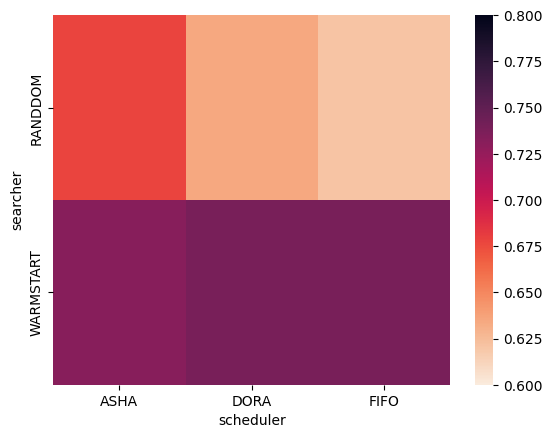

In [18]:
heatmap_df = test_results_df.groupby(["searcher", "scheduler"])["test_accuracy"].mean().reset_index()

sns.heatmap(pd.pivot_table(data=heatmap_df, index='searcher',columns='scheduler',values='test_accuracy'), cmap=sns.cm.rocket_r, vmax=0.8, vmin=0.6)

## Violin plot


<AxesSubplot:xlabel='searcher', ylabel='val_accuracy_mean'>

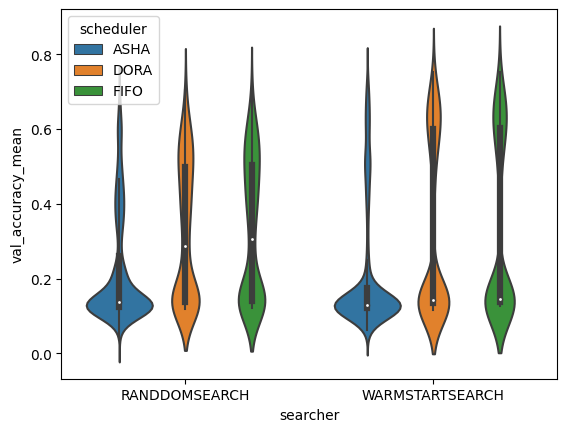

In [19]:
sns.violinplot(data=performance_df, x="searcher", y="val_accuracy_mean", hue="scheduler")

<AxesSubplot:xlabel='scheduler', ylabel='val_accuracy_mean'>

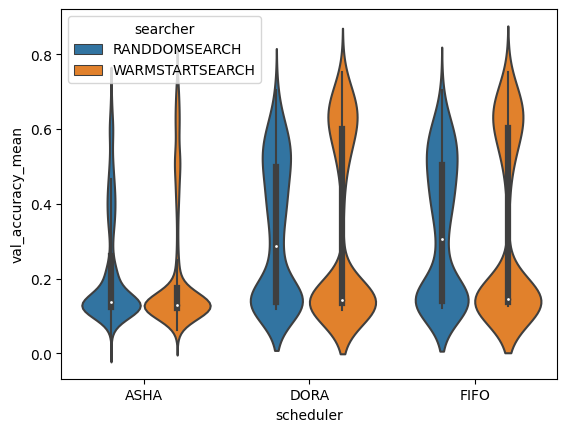

In [20]:
sns.violinplot(data=performance_df, x="scheduler", y="val_accuracy_mean", hue="searcher")

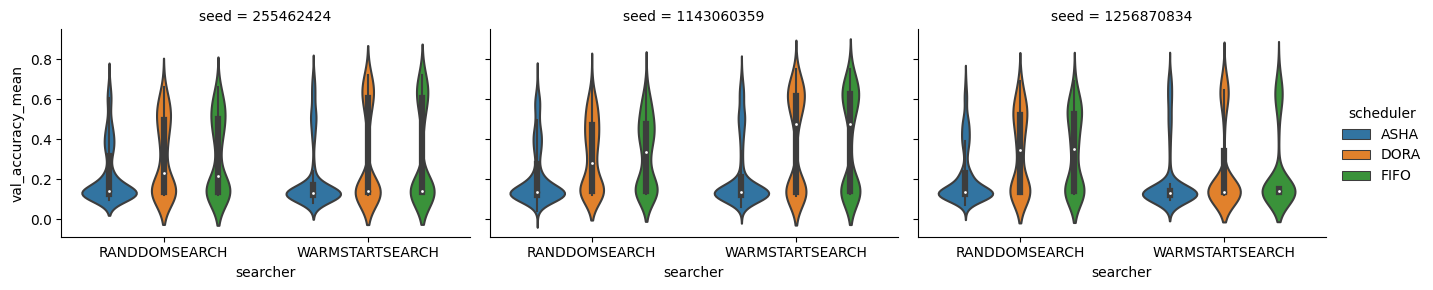

In [21]:
sns.catplot(
    data=performance_df,
    x="searcher",
    y="val_accuracy_mean",
    hue="scheduler",
    col="seed",
    kind="violin",
    col_wrap=3,
    height=3,
    aspect=1.5,
)

## Plot performance over time

<AxesSubplot:xlabel='runtime_minutes', ylabel='val_accuracy_mean'>

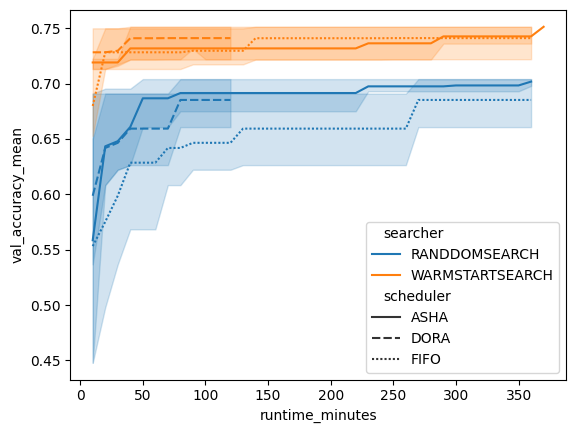

In [22]:
cum_max_df = pd.DataFrame()

for searcher in performance_df['searcher'].unique():
    searcher_df = performance_df[performance_df['searcher'] == searcher]
    for scheduler in searcher_df['scheduler'].unique():
        scheduler_df = searcher_df[searcher_df['scheduler'] == scheduler]
        
        for seed in scheduler_df['seed'].unique():
            seed_df = scheduler_df[scheduler_df['seed'] == seed][["runtime_minutes", "val_accuracy_mean"]].set_index("runtime_minutes").sort_index().cummax()
            seed_new_df = pd.DataFrame()
            seed_new_df["runtime_minutes"] = range(10, int(seed_df.index.max()) + 10, 10)
            seed_new_df["val_accuracy_mean"] = seed_new_df.apply(lambda x: seed_df[seed_df.index < x["runtime_minutes"]]["val_accuracy_mean"].max(), axis=1)
            seed_new_df["seed"] = seed
            seed_new_df["searcher"] = searcher
            seed_new_df["scheduler"] = scheduler
            
            cum_max_df = cum_max_df.append(seed_new_df)

        
sns.lineplot(data=cum_max_df, x="runtime_minutes", y="val_accuracy_mean", hue="searcher", style="scheduler")


## Scatter plot matrix

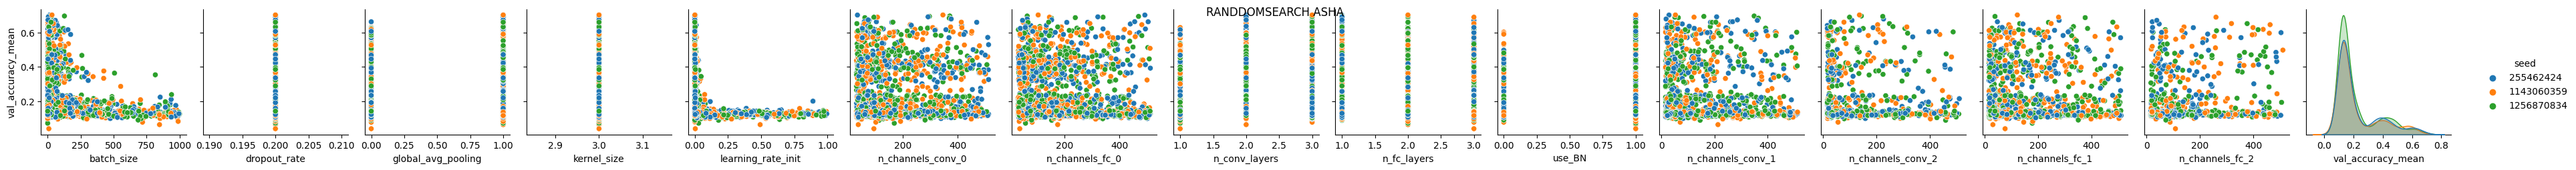

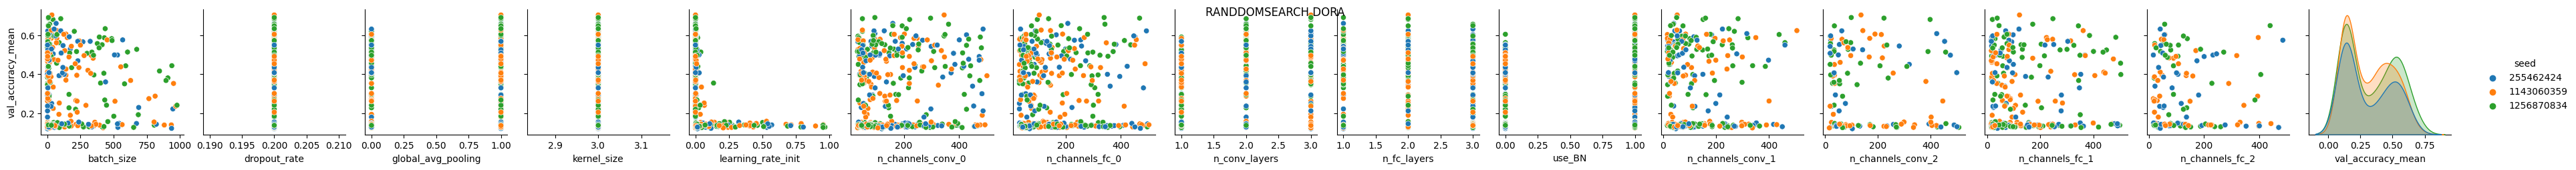

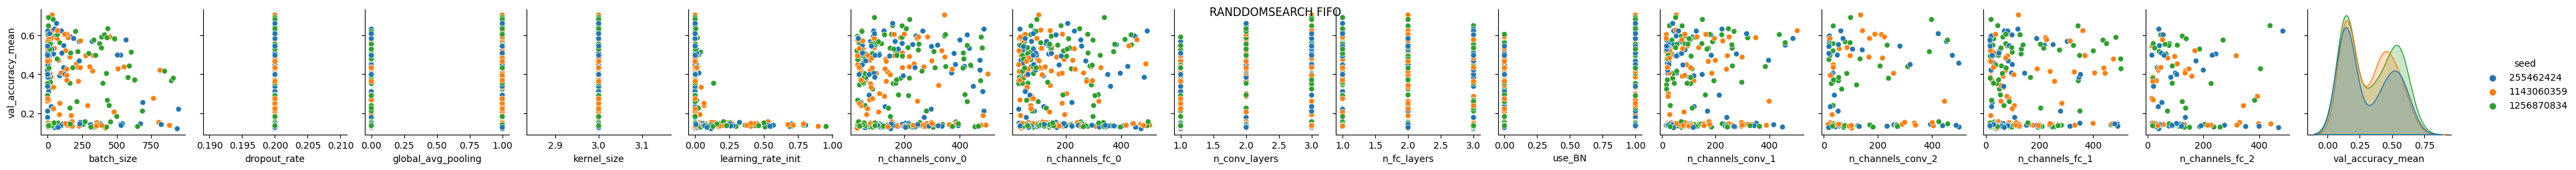

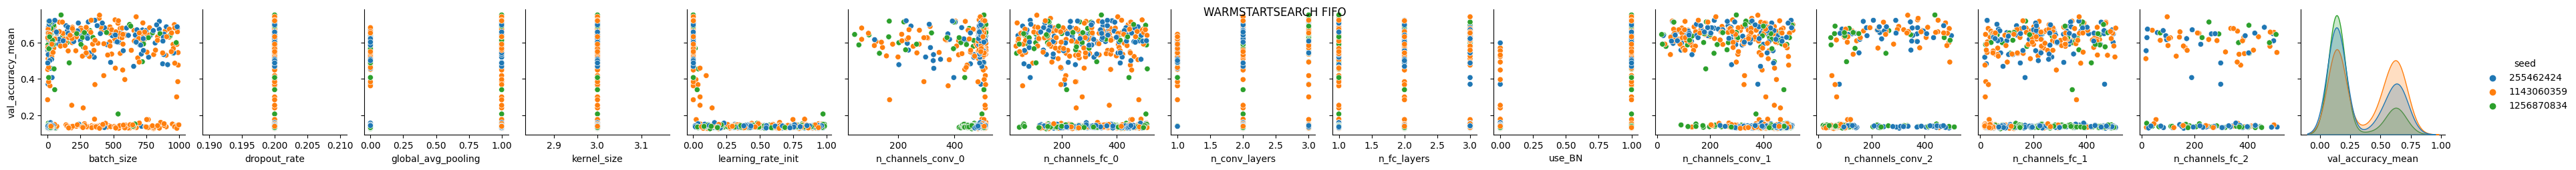

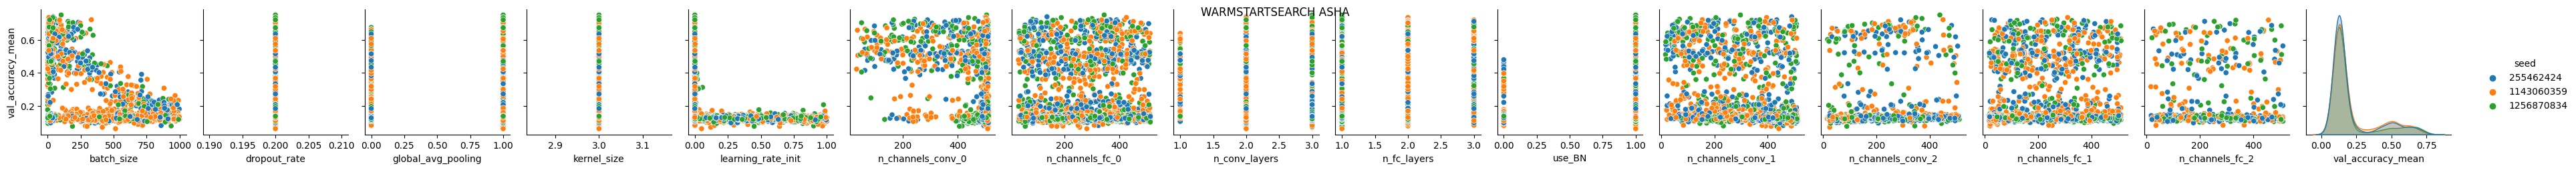

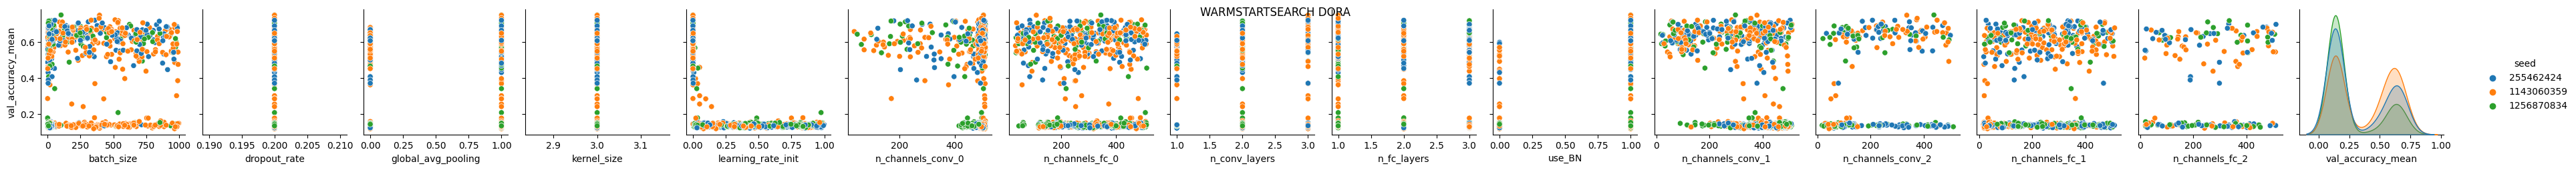

In [23]:
for searcher in config_df['searcher'].unique():
    searcher_df = config_df[config_df['searcher'] == searcher]
    for scheduler in searcher_df['scheduler'].unique():
        scheduler_df = searcher_df[searcher_df['scheduler'] == scheduler]
        sns.pairplot(scheduler_df, hue="seed", y_vars="val_accuracy_mean", kind='scatter').fig.suptitle(f"{searcher} {scheduler}")
    

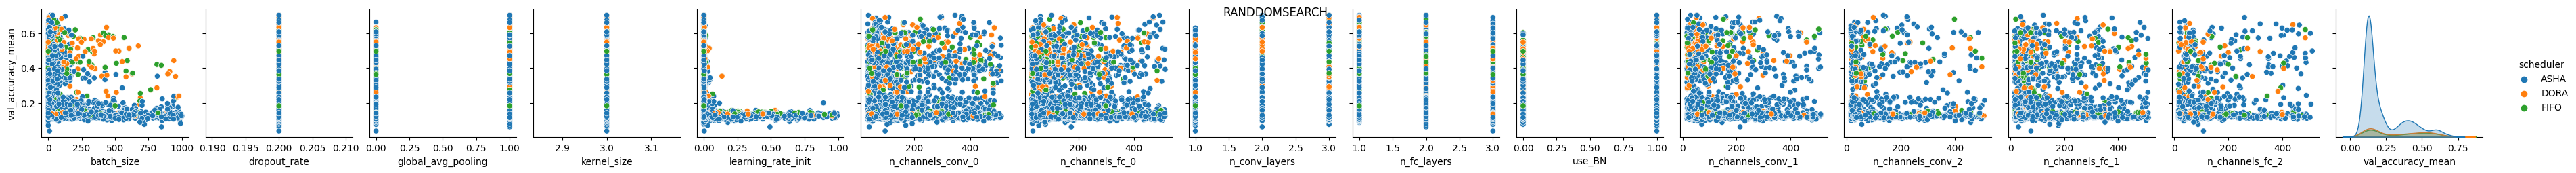

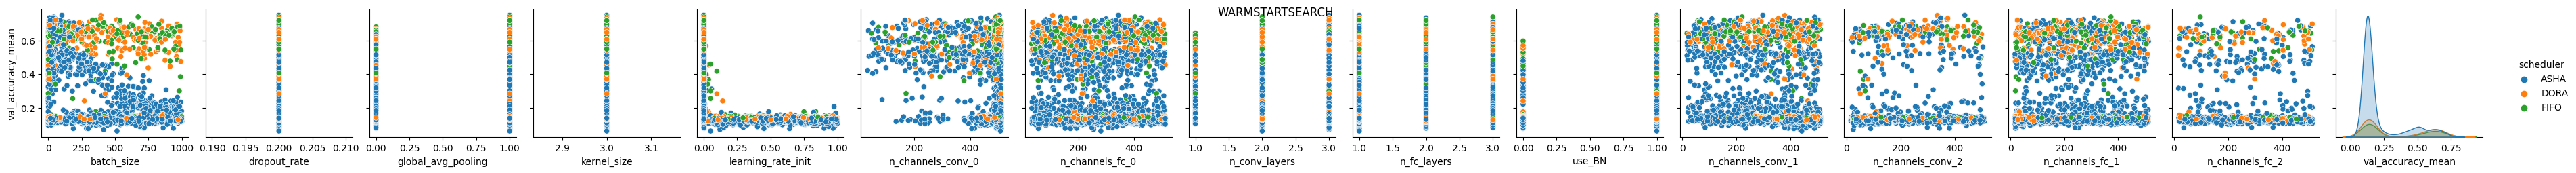

In [24]:
for searcher in config_df['searcher'].unique():
    searcher_df = config_df[config_df['searcher'] == searcher]
    sns.pairplot(searcher_df, hue="scheduler", y_vars="val_accuracy_mean").fig.suptitle(f"{searcher}")


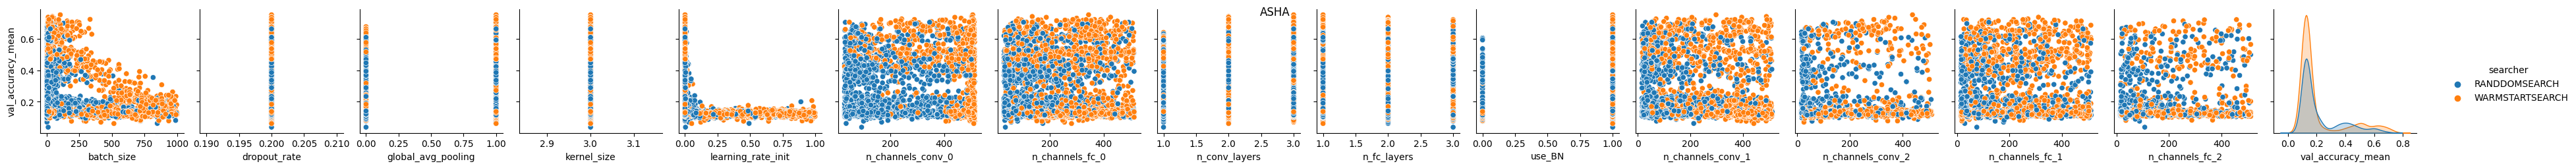

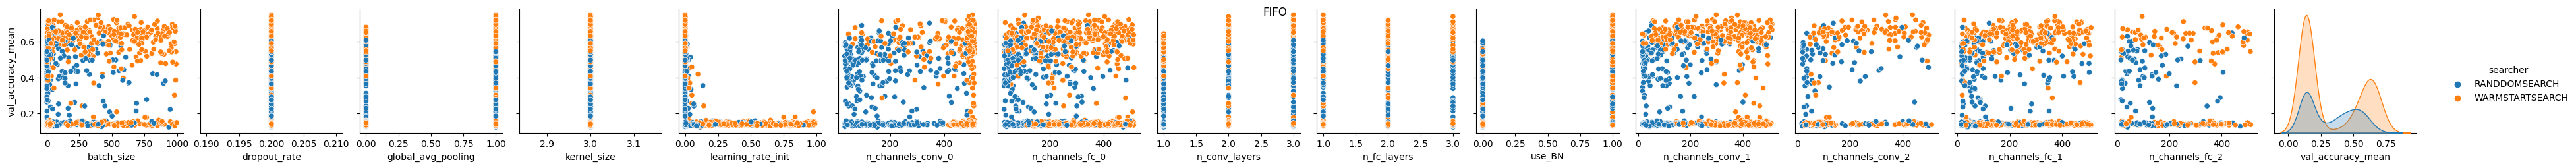

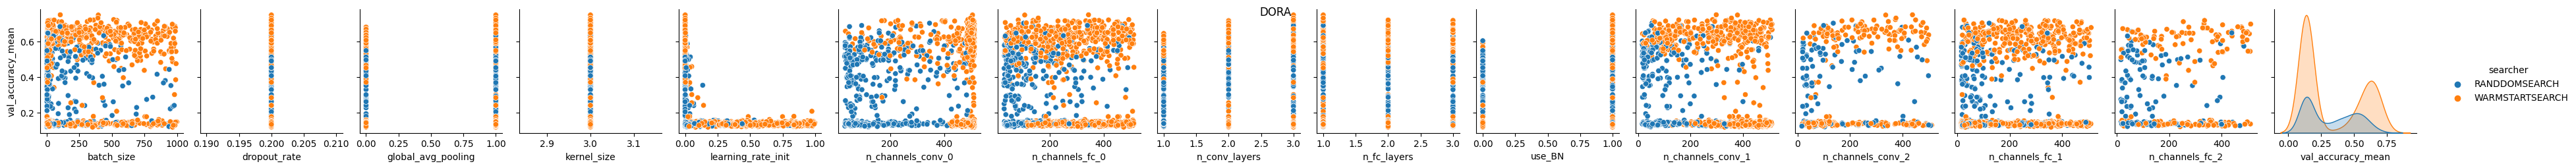

In [25]:
for scheduler in config_df['scheduler'].unique():
    scheduler_df = config_df[config_df['scheduler'] == scheduler]
    sns.pairplot(scheduler_df, hue="searcher", y_vars="val_accuracy_mean").fig.suptitle(f"{scheduler}")


## 